# Background

### Preparing the Dataset

For this reinforcement learning (RL) project, we do not have real user interaction data yet because the EVAT gamification system is still under development. To solve this, we generate a **synthetic dataset** called `simulated_user_actions.json`.

This dataset contains random user actions that are designed according to our gamification plan. The possible actions are:

* `check_in`
* `report_fault`
* `validate_ai_prediction`
* `discover_new_station_in_black_spot`
* `use_route_planner`
* `ask_chatbot_question`

We use weighted random generation to make some actions more common than others. For example, *check-in* and *chatbot question* are more frequent, while *black spot discovery* is rare. We also add around 10% chance that a user does nothing, to simulate inactivity.

Finally, we generate multiple users (about 30–40) and each one performs around 50 actions. This gives us a dataset of around 2000 user actions. The dataset is stored in JSON format, and each record looks like this:

```json
{
  "user_id": "user_15",
  "action_type": "check_in"
}
```

This synthetic dataset is important because it allows us to train and test our RL environment even before real data is collected.

---

### EVATGamificationEnv Model

We design a **Gym-compatible environment** called `EVATGamificationEnv`. It follows the OpenAI Gymnasium interface so we can train with Stable-Baselines3 easily.

The environment defines:

* **Action space:** 6 discrete actions (check-in, report fault, etc).
* **Observation space:** a normalized vector that keeps track of how many times each action has been used in the episode.
* **Reward shaping:** Each action gives a base reward (e.g., check-in = 10, report fault = 25, black spot discovery = 120). Then we scale and clip the reward to make training stable.

We also add some shaping rules:

* *Diminishing returns:* repeating the same action many times reduces reward.
* *Exploration bonus:* the first time an action is tried, extra reward is given.
* *Diversity bonus:* switching actions also gives a small bonus.

Each episode simulates a short sequence of user actions (30–80 steps). At the end, the agent has a points balance that reflects how well it performed.

---

### Purpose of Training

The purpose of training the RL model is not to predict one single action but to **find an optimal policy of user interactions** that maximize long-term reward. In other words, we want to understand:

* Which actions are more beneficial in the gamification system.
* How a balance between different actions (diversity) leads to better rewards.
* How reward shaping influences the strategy the agent learns.

By training an RL agent, we can test our gamification design before deploying to real users. If the agent always learns a trivial strategy (like spamming only one action), it means our reward shaping is not well-balanced. If the agent learns a balanced strategy, then the gamification design is more robust.

### Training Setup

After we prepared the dataset and the `EVATGamificationEnv` environment, the next step was to train a reinforcement learning agent. We choose **Proximal Policy Optimization (PPO)** from the `stable-baselines3` library because it is one of the most stable and widely used policy-gradient algorithms.


In [1]:
# Load user_action_data
import json
from EVATGamificationEnv import EVATGamificationEnv
from stable_baselines3.common.callbacks import EvalCallback
from stable_baselines3.common.monitor import Monitor
from stable_baselines3.common.env_util import make_vec_env
from stable_baselines3 import PPO
import os
import numpy as np
import matplotlib.pyplot as plt


2025-09-18 18:11:00.167713: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-09-18 18:11:00.179073: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1758183060.193069  179298 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1758183060.197544  179298 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1758183060.208621  179298 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking 

In [2]:
# Load simulated user actions
with open("simulated_user_actions.json") as f:
    user_action_data = json.load(f)

In [3]:
# Create monitored vectorized environment for training
def make_env():
    env = EVATGamificationEnv(user_action_data)
    return Monitor(env)

# Vectorized env
vec_env = make_vec_env(make_env, n_envs=1)

In [4]:
# Setup evaluation environment (non-vectorized)
eval_env = Monitor(EVATGamificationEnv(user_action_data))

# Set up evaluation logging
log_path = "./eval_logs/"
os.makedirs(log_path, exist_ok=True)

# Create EvalCallback to log evaluation results and save best model
eval_callback = EvalCallback(
    eval_env,
    best_model_save_path=log_path,
    log_path=log_path,
    eval_freq=200,                # Evaluate every 1000 steps
    deterministic=True,
    render=False
)

In [5]:
# Train PPO with EvalCallback
model = PPO("MlpPolicy", vec_env, verbose=1)
model.learn(total_timesteps=20000, callback=eval_callback)

# Save model
model.save("ppo_evat_reward_model")

Using cpu device
Eval num_timesteps=200, episode_reward=14.31 +/- 0.95
Episode length: 56.00 +/- 10.28
---------------------------------
| eval/              |          |
|    mean_ep_length  | 56       |
|    mean_reward     | 14.3     |
| time/              |          |
|    total_timesteps | 200      |
---------------------------------
New best mean reward!
Eval num_timesteps=400, episode_reward=13.83 +/- 1.34
Episode length: 52.60 +/- 14.14
---------------------------------
| eval/              |          |
|    mean_ep_length  | 52.6     |
|    mean_reward     | 13.8     |
| time/              |          |
|    total_timesteps | 400      |
---------------------------------
Eval num_timesteps=600, episode_reward=13.04 +/- 1.43
Episode length: 46.00 +/- 15.40
---------------------------------
| eval/              |          |
|    mean_ep_length  | 46       |
|    mean_reward     | 13       |
| time/              |          |
|    total_timesteps | 600      |
-----------------------

In [6]:
#  Load later if needed (optional)
# model = PPO.load("ppo_evat_reward_model", env=vec_env)

### Evaluation Reward Curve

During training, the model was evaluated every 200 timesteps. At the beginning, the episode reward was around **13–15**, but later the mean reward improved to **above 24** in some evaluation runs. The episode length also increased to around **60 steps** on average, which means the agent learned to prolong interaction instead of ending episodes quickly.

To visualize the reward trend, we loaded the evaluation logs and plotted both the raw and smoothed reward curve:


timesteps: 102
results_mean: 102


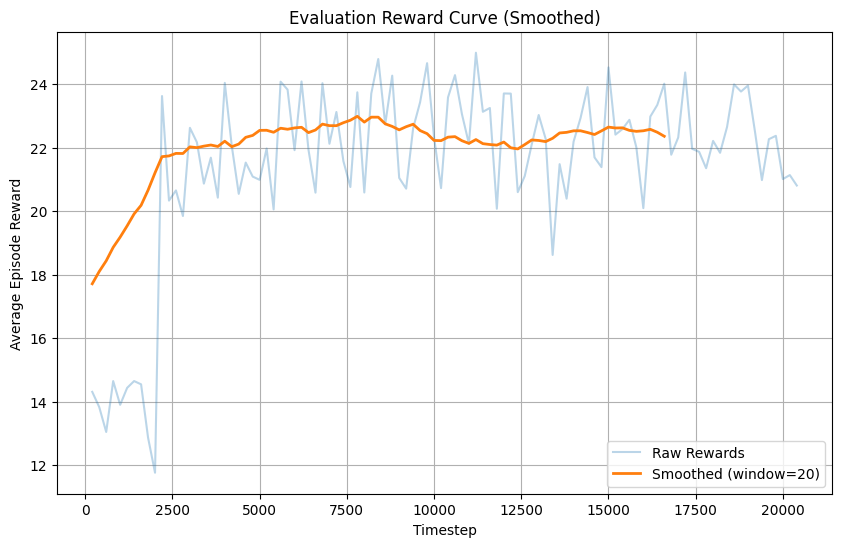

In [7]:
# Load evaluation results
results = np.load(os.path.join(log_path, "evaluations.npz"))
timesteps = results["timesteps"]
results_mean = results["results"].mean(axis=1)

# Check lengths
print("timesteps:", len(timesteps))
print("results_mean:", len(results_mean))

# Moving average smoothing function
def moving_average(x, window=20):
    if len(x) < window:
        return x  # not enough points to smooth
    return np.convolve(x, np.ones(window)/window, mode="valid")

# Apply smoothing
smoothed_rewards = moving_average(results_mean, window=20)

# Plot raw and smoothed
plt.figure(figsize=(10, 6))
plt.plot(timesteps, results_mean, alpha=0.3, label="Raw Rewards")
plt.plot(timesteps[:len(smoothed_rewards)], smoothed_rewards, label="Smoothed (window=20)", linewidth=2)
plt.xlabel("Timestep")
plt.ylabel("Average Episode Reward")
plt.title("Evaluation Reward Curve (Smoothed)")
plt.legend()
plt.grid(True)
plt.show()



The curve showed a clear **upward improvement**, then stabilized around a high plateau. This means the PPO agent discovered a consistent sequence of actions that gave high cumulative rewards.  

In [8]:
# Inspect content
print("Available evaluation logs:", results.files)
# ['timesteps', 'results', 'ep_lengths']

Available evaluation logs: ['timesteps', 'results', 'ep_lengths']


### Visualizing Agent Behavior

To understand how the agent behaves, we recorded the actions chosen during evaluation episodes.

In [9]:
# Visualize agent behavior during one episode
def visualize_agent_behavior(model, env, action_map, max_steps=100):
    obs, _ = env.reset()
    done = False
    step = 0
    
    action_history = []
    reward_history = []
    cumulative_reward = 0
    
    while not done and step < max_steps:
        action, _ = model.predict(obs, deterministic=False)  # stochastic sampling
        obs, reward, terminated, truncated, info = env.step(action)
        done = terminated or truncated
        
        action_str = action_map[int(action)]
        action_history.append(action_str)
        reward_history.append(reward)
        cumulative_reward += reward
        
        step += 1
        
    return action_history, reward_history

Then we summarized the results:

In [10]:
from collections import Counter

def plot_action_distribution(action_history):
    counter = Counter(action_history)
    actions = list(counter.keys())
    counts = list(counter.values())
    
    plt.figure(figsize=(8, 4))
    plt.bar(actions, counts)
    plt.title("Agent Action Frequency")
    plt.ylabel("Count")
    plt.xticks(rotation=45)
    plt.grid(axis='y')
    plt.tight_layout()
    plt.show()

In [11]:
from collections import defaultdict

def plot_avg_reward_per_action(action_history, reward_history):
    reward_sum = defaultdict(float)
    action_count = defaultdict(int)

    for a, r in zip(action_history, reward_history):
        reward_sum[a] += r
        action_count[a] += 1

    avg_rewards = {a: reward_sum[a] / action_count[a] for a in reward_sum}

    plt.figure(figsize=(8, 4))
    plt.bar(avg_rewards.keys(), avg_rewards.values())
    plt.title("Average Reward per Action")
    plt.ylabel("Avg Reward")
    plt.xticks(rotation=45)
    plt.grid(axis='y')
    plt.tight_layout()
    plt.show()

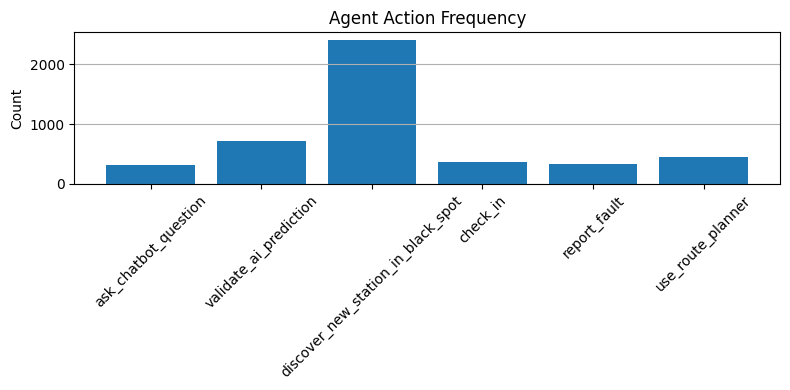

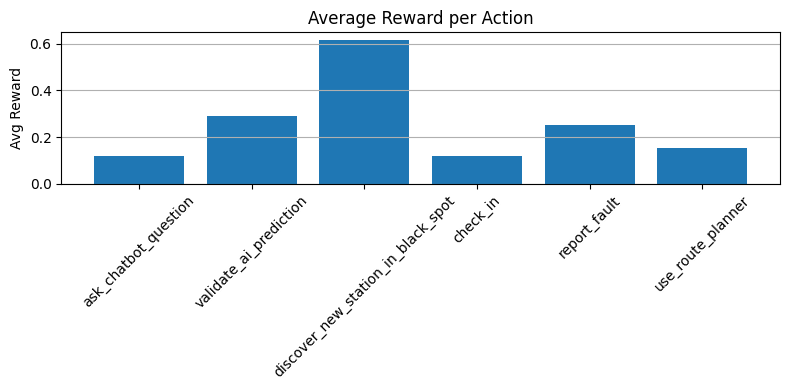

In [ ]:
action_map=[
        "check_in",
        "report_fault",
        "validate_ai_prediction",
        "discover_new_station_in_black_spot",
        "use_route_planner",
        "ask_chatbot_question"
        ]
all_actions, all_rewards = [], []
for _ in range(100):
    acts, rews = visualize_agent_behavior(model, Monitor(EVATGamificationEnv(user_action_data)), action_map, max_steps=50)
    all_actions.extend(acts)
    all_rewards.extend(rews)

plot_action_distribution(all_actions)
plot_avg_reward_per_action(all_actions, all_rewards)


From the action distribution, the trained model tends to **repeat a small set of high-value actions** (like *discovering black spot* or *AI validation*) because the reward shaping gives them bigger values. However, diversity bonuses also encouraged the agent to explore different actions occasionally.

### Interpretation of Results

1. **Learning progress:** The evaluation reward improved steadily from \~14 to \~24, which shows the PPO agent adapted well to the environment.
2. **Stable plateau:** After \~10k timesteps, the reward curve flattened. This is normal since the policy converged to a consistent behavior.
3. **Agent preference:** The agent showed a bias toward actions with high base rewards but still balanced with diversity to avoid repeating one action.
4. **Episode length:** Longer episode lengths indicate the agent is learning strategies to extend interactions, not just finish episodes quickly.
